In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import numpy as np

import ray
from ray.rllib.agents import ddpg
from ray.tune import register_env

from src.samplers.load_samplers import load_samplers
from src.environments.create_env import create_env
from src.optimization.heuristic_greedy import compute_greedy_heuristic
from src.optimization.deterministic_solution import compute_deterministic_solution

ray.init()

%matplotlib inline

In [3]:
def plot_results(env, results_list, figsize=(12, 7)):
    plt.figure(figsize=figsize)
    plt.subplot(121)
    i_violations = [res['i_constraints_violation'] for res in results_list]
    p_violations = [res['power_flow_constraints_violation'] for res in results_list]
    plt.plot(env.timesteps_str[:-1], i_violations, label='i_violation')
    plt.plot(env.timesteps_str[:-1], p_violations, label='p_violation')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Constraint violations')

    plt.subplot(122)
    rewards = [res['reward'] for res in results_list]
    feeders_price = [res['feeders_power_price'] for res in results_list]
    pvs_price = [res['pvs_power_price'] for res in results_list]
    evs_welfare = [res['evs_social_welfare'] for res in results_list]

    plt.plot(env.timesteps_str[:-1], rewards, label='total reward')
    plt.plot(env.timesteps_str[:-1], feeders_price, label='feeders price')
    plt.plot(env.timesteps_str[:-1], pvs_price, label='PVs price')
    plt.plot(env.timesteps_str[:-1], evs_welfare, label='EVs welfare')
    _ = plt.xticks(env.timesteps_str[::6])
    _ = plt.legend()
    _ = plt.title('Objective')

### Config and data loading

In [4]:
config = {'path_to_data': './data/', 
          't0_hr': 6., # When the episode start (default value 6AM)
          'dt_min': 30, # Timestep size
          'ev_dt_min': 60, # Timestep size for EV arrivals
          'ev_sampling_dt_min': 60,  # How EV sessions are sampled from the data
          'apply_gaussian_noise': False, # Make data noisy
          'ev_utility_coef_mean': 1, # Mean value of the utility coefficient for the EVs
          'ev_utility_coef_scale': 0.13, # STD of the utility coefficient for the EVs
          'days_per_month_train': 20, # Days per month for training 
          'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11',],
           # Months to sample EV sessions for training 
          'grid_to_use': 'ieee16', # What grid topology to use. Now supports only IEEE16. 
          'ev_session_months_test': ['05', '12'], # Months to sample EV sessions for test 
          'n_ps_pvs': 4, # Amount of solar panels that use PecanStreet data
          'n_canopy_pvs': 0, # Amount of solar panels that use canopy data
          'canopy_pv_rated_power': 250, # Rated power of these panels
          'n_loads': 0, # Amount of inflexible loads
          'n_feeders': 1, # Amount of feeders
          'n_ev_chargers': 4, # Amount of EV chargers
          
          'ps_pvs_rated_power': 4, # Rated power of these panels
          'avg_evs_per_day': 3.5, # Scaling of the EV arrival rate
          'feeder_p_min': -5, # Capacity of the feeders
          'g': 4, # Conductance of each line
          'i_max': 25, # Capacity of each line
          # new and improved cool config options
          'environment_type': 'normal', # normal / gym
          'device_constraint_violation_mode': 'ignore', # ignore / reward
          'constraint_violation_mode': 'ignore', # ignore / reward
          'epochs': 15,
          }

In [5]:
# Preload samplers, it is necessary to avoid re-loading data each time env is created
(ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
 price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

{'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'normal', 'device_constraint_violation_mode': 'ignore', 'constraint_violation_mode': 'ignore', 'epochs': 15}


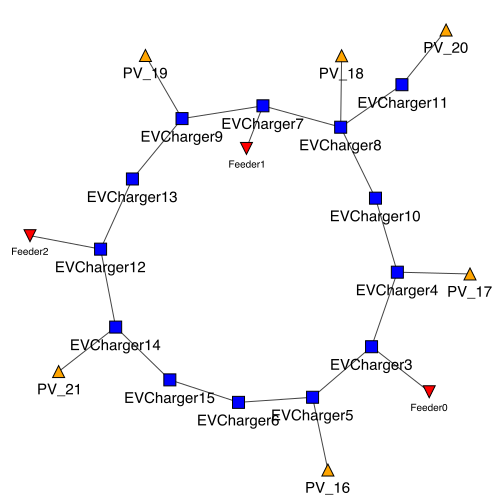

In [6]:
# Create environment
env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
env.plot_grid(bbox=(0, 0, 500, 500))

### Sample runs using heuristics

Reward = 319.60


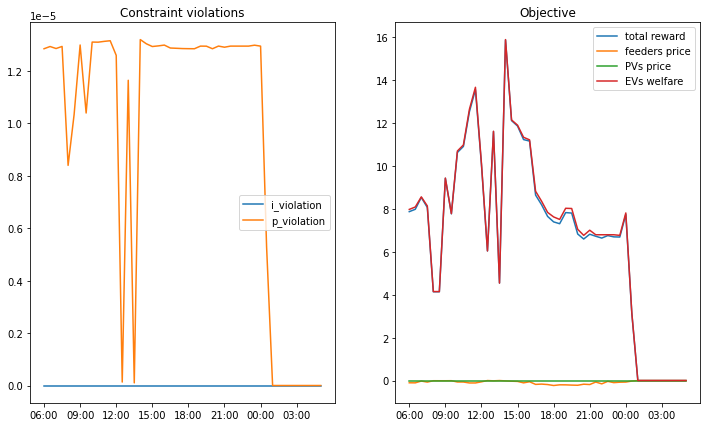

In [7]:
# Greedy heuristic which solves single-timestep OPF
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=False, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

Reward = 319.78


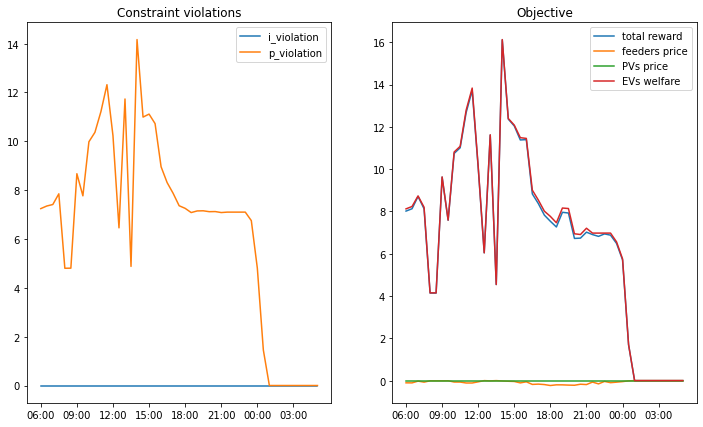

In [8]:
# Greedy heuristic which solves single-timestep OPF using lossless model
# It gets higher reward, but violates the power-flow constraints. 
np.random.seed(42)
env.reset(episode_index=0, train=True)
results_list = []
total_reward = 0
while not env.done:
    # print('t=%s' % env.t_str)
    p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, u_t = env.compute_current_state()
    p, v, model = compute_greedy_heuristic(u_t, p_lbs_t, p_ubs_t, v_lbs_t, v_ubs_t, 
                                           env.conductance_matrix, env.i_max_matrix, 
                                           lossless=True, tee=False)
    result = env.step(p, v)
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Same simulation but using a deterministic planner

Reward = 356.92


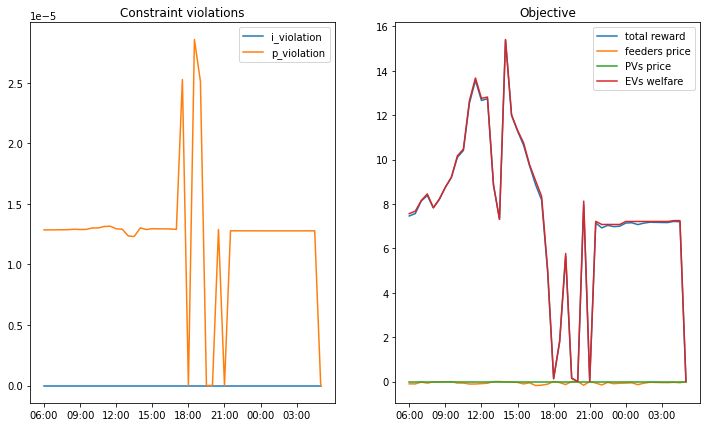

In [9]:
# Deterministic solution solves the full planning problem using perfect knowledge of the future.
# As expected, it receives higher reward.
np.random.seed(42)
env.reset(episode_index=0, train=True)

p_lbs, p_ubs, v_lbs, v_ubs, u, evs_dict = env.compute_full_state(uncertainty='deterministic')
p_det, v_det, model = compute_deterministic_solution(env.dt_min, evs_dict, u[0], p_lbs[0], 
                                                     p_ubs[0], v_lbs[0], v_ubs[0], 
                                                     env.conductance_matrix, env.i_max_matrix,
                                                     lossless=False, tee=False)
results_list = []
total_reward = 0
while not env.done:
    result = env.step(p_det[env.t_ind], v_det[env.t_ind])
    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### New cool implementation using DDPG

In [10]:
# set environment type to gym for the next sections
config['environment_type'] = 'gym'

def env_creator(a):
    (ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
     price_sampler, price_metadata, ev_sampler, elaadnl_metadata) = load_samplers(config)

    return create_env(
        config,
        ps_samplers_dict,
        ps_metadata,
        canopy_sampler,
        canopy_metadata,
        price_sampler,
        price_metadata,
        ev_sampler,
        elaadnl_metadata
    )
register_env("my_env", env_creator)

### No modifications for constraints

In [11]:
trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

2022-05-16 22:46:26,368	INFO simple_q.py:161 -- In multi-agent mode, policies will be optimized sequentially by the multi-GPU optimizer. Consider setting `simple_optimizer=True` if this doesn't work for you.
2022-05-16 22:46:26,372	INFO trainer.py:864 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.


KeyboardInterrupt: 

(RolloutWorker pid=10245) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'ignore', 'constraint_violation_mode': 'ignore', 'epochs': 15}


### Large negative reward for wrong device assignment

(RolloutWorker pid=9899) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'reward', 'constraint_violation_mode': 'ignore', 'epochs': 1}


(RolloutWorker pid=9899) 2022-05-16 22:38:09,003	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=9899) 2022-05-16 22:38:09,004	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-16 22:38:09,197	INFO trainable.py:152 -- Trainable.setup took 136.198 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-05-16 22:38:09,199	WARNING util.py

Reward = -89668.62


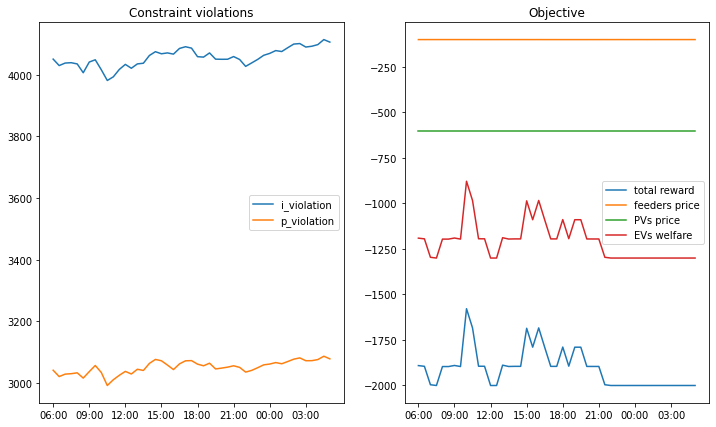

In [ ]:
config['device_constraint_violation_mode'] = 'reward'

trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### Large negative reward for constraint violation, no negative reward for wrong device assignment

(RolloutWorker pid=9937) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'ignore', 'constraint_violation_mode': 'reward', 'epochs': 1}


(RolloutWorker pid=9937) 2022-05-16 22:40:31,297	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=9937) 2022-05-16 22:40:31,297	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-16 22:40:31,476	INFO trainable.py:152 -- Trainable.setup took 131.978 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-05-16 22:40:31,478	WARNING util.py

(RolloutWorker pid=9937) 2618.531641670144 constraints violated!
(RolloutWorker pid=9937) 189.02657270431519 constraints violated!
(RolloutWorker pid=9937) 162.11274549365044 constraints violated!
(RolloutWorker pid=9937) 150.7526233792305 constraints violated!
(RolloutWorker pid=9937) 180.46635448932648 constraints violated!
(RolloutWorker pid=9937) 147.7157562971115 constraints violated!
(RolloutWorker pid=9937) 184.33841198682785 constraints violated!
(RolloutWorker pid=9937) 183.35154309868813 constraints violated!
(RolloutWorker pid=9937) 151.33434414863586 constraints violated!
(RolloutWorker pid=9937) 161.50434717535973 constraints violated!
(RolloutWorker pid=9937) 185.49856662750244 constraints violated!
(RolloutWorker pid=9937) 183.11530947685242 constraints violated!
(RolloutWorker pid=9937) 175.6060329079628 constraints violated!
(RolloutWorker pid=9937) 180.0 constraints violated!
(RolloutWorker pid=9937) 176.73912808299065 constraints violated!
(RolloutWorker pid=9937) 19

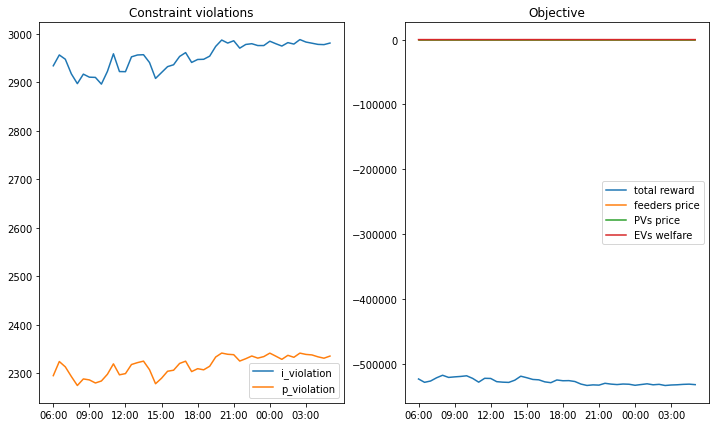

In [ ]:
config['device_constraint_violation_mode'] = 'ignore'
config['constraint_violation_mode'] = 'reward'

trainer = ddpg.DDPGTrainer(
    env="my_env",
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
)
for _ in range(config['epochs']):
    trainer.train()

np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

### trying both just to see what happens :D

(RolloutWorker pid=9972) {'path_to_data': './data/', 't0_hr': 6.0, 'dt_min': 30, 'ev_dt_min': 60, 'ev_sampling_dt_min': 60, 'apply_gaussian_noise': False, 'ev_utility_coef_mean': 1, 'ev_utility_coef_scale': 0.13, 'days_per_month_train': 20, 'ev_session_months_train': ['01', '02', '03', '04', '06', '07', '08', '09', '10', '11'], 'grid_to_use': 'ieee16', 'ev_session_months_test': ['05', '12'], 'n_ps_pvs': 4, 'n_canopy_pvs': 0, 'canopy_pv_rated_power': 250, 'n_loads': 0, 'n_feeders': 1, 'n_ev_chargers': 4, 'ps_pvs_rated_power': 4, 'avg_evs_per_day': 3.5, 'feeder_p_min': -5, 'g': 4, 'i_max': 25, 'environment_type': 'gym', 'device_constraint_violation_mode': 'reward', 'constraint_violation_mode': 'reward', 'epochs': 1}


(RolloutWorker pid=9972) 2022-05-16 22:42:53,724	WARNING rollout_worker.py:498 -- We've added a module for checking environments that are used in experiments. It will cause your environment to fail if your environment is not set upcorrectly. You can disable check env by setting `disable_env_checking` to True in your experiment config dictionary. You can run the environment checking module standalone by calling ray.rllib.utils.check_env(env).
(RolloutWorker pid=9972) 2022-05-16 22:42:53,724	WARNING env.py:120 -- Your env doesn't have a .spec.max_episode_steps attribute. This is fine if you have set 'horizon' in your config dictionary, or `soft_horizon`. However, if you haven't, 'horizon' will default to infinity, and your environment will not be reset.
2022-05-16 22:42:53,928	INFO trainable.py:152 -- Trainable.setup took 131.078 seconds. If your trainable is slow to initialize, consider setting reuse_actors=True to reduce actor creation overheads.
2022-05-16 22:42:53,930	WARNING util.py

(RolloutWorker pid=9972) 3463.551252257384 constraints violated!
(RolloutWorker pid=9972) 164.8979602754116 constraints violated!
(RolloutWorker pid=9972) 196.9533045589924 constraints violated!
(RolloutWorker pid=9972) 176.2087458372116 constraints violated!
(RolloutWorker pid=9972) 203.28815191984177 constraints violated!
(RolloutWorker pid=9972) 182.2314402461052 constraints violated!
(RolloutWorker pid=9972) 179.75027084350586 constraints violated!
(RolloutWorker pid=9972) 190.0 constraints violated!
(RolloutWorker pid=9972) 181.34033784270287 constraints violated!
(RolloutWorker pid=9972) 162.42225378751755 constraints violated!
(RolloutWorker pid=9972) 185.0 constraints violated!
(RolloutWorker pid=9972) 145.10512486100197 constraints violated!
(RolloutWorker pid=9972) 178.3846092224121 constraints violated!
(RolloutWorker pid=9972) 197.22726553678513 constraints violated!
(RolloutWorker pid=9972) 152.08352342247963 constraints violated!
(RolloutWorker pid=9972) 196.8092913925647

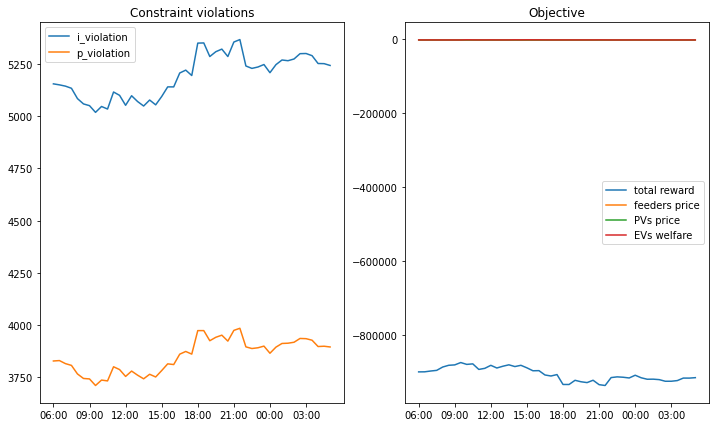

In [ ]:
config['device_constraint_violation_mode'] = 'reward'
config['constraint_violation_mode'] = 'reward'

trainer = ddpg.DDPGTrainer(
    env="my_env",
    # Stopping condition
    # stop={"episode_reward_mean":200},

    # Config
    # The default DDPG specific config is used with required 
    # Options for the config are in the default DDPG config: 
    # https://docs.ray.io/en/latest/rllib/rllib-algorithms.html#ddpg
    config={
        "env": "my_env",
        "framework": "torch",
        "num_gpus":0,
        "num_workers":1,
    },
    # checkpoint_freq=1
)
for _ in range(config['epochs']):
    trainer.train()

# Deterministic solution solves the full planning problem using perfect knowledge of the future.
# As expected, it receives higher reward.
np.random.seed(42)
gym_env = create_env(config, ps_samplers_dict, ps_metadata, canopy_sampler, canopy_metadata,
                 price_sampler, price_metadata, ev_sampler, elaadnl_metadata)
state = gym_env.reset(episode_index=0, train=True)

results_list = []
total_reward = 0
while not gym_env.done:
    action = trainer.get_policy().compute_actions(state)[0]
    next_state, reward, done, result = gym_env.step(action)
    state = next_state

    total_reward += result['reward']
    results_list.append(result)
print('Reward = %.2f' % total_reward)
plot_results(env, results_list, figsize=(12, 7))

The goal of the project is to come up with an RL based method that computes nodal powers and voltages that maximize the objective while keeping the constraint violations small.  The above simulations use the benchmarks that you should be comparing to. Clearly, you want to beat the greedy heuristic , but you can't beat the determenistic planner as it is the absolute optimal solution (assuming known future).